<a href="https://www.kaggle.com/code/dalloliogm/logistic-regression-xgboost-lightgbm-ensemble?scriptVersionId=229039225" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Rain prediction using Logistic Regression

This notebook predicts rainfall using a simple Logistic Regression model.

## Parameters and options

In [1]:
config = {
    "features": ['day', 
                 'pressure', 
                 'maxtemp', 
                 'temparature', 
                 'mintemp', 
                 'dewpoint', 
                 'humidity', 
                 'cloud', 
                 'sunshine', 
                 'winddirection', 
                 'windspeed'
                 ],
    # Note: in this notebook https://www.kaggle.com/code/hopesb/rain-fall-prediction/notebook they removed:
    # ["mintemp", "temparature", "maxtemp", "winddirection"
    "clustering_variables": ['day', 'temparature', 'sunshine', 'cloud', 'windspeed'],
    "n_clusters": 3,
    "n_lags": 5,
    "lag_columns": ['humidity', 'temparature', 'pressure', 'cloud', 'windspeed', 'dewpoint', 'sunshine'],
    "device": "cpu"
}

## Importing libraries and reading files

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning)

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


def plot_cv_scores(cv_scores, title):
    """Plot cross-validation ROC AUC scores."""
    plt.figure(figsize=(10, 6))
    num_folds = len(cv_scores)
    plt.plot(range(1, num_folds + 1), cv_scores, marker='o', linestyle='--', color='b')
    plt.axhline(y=cv_scores.mean(), color='r', linestyle='-', label=f'Mean: {cv_scores.mean():.4f}')
    plt.xlabel('Fold Number', fontsize=12)
    plt.ylabel('ROC AUC', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, num_folds + 1, 2))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

def evaluate_pipeline(pipeline, X, y, pipeline_name, n_splits=5, n_repeats=10, random_state=666):
    """
    Evaluate a pipeline using repeated stratified k-fold cross-validation and plot the results.
    
    Parameters:
        pipeline: The sklearn Pipeline to evaluate.
        X: Feature DataFrame.
        y: Target array or Series.
        pipeline_name: String, name of the pipeline (used for printing/plot titles).
        n_splits: Number of folds (default 5).
        n_repeats: Number of repeats (default 10).
        random_state: Random seed for reproducibility.
    
    Returns:
        cv_scores: Array of cross-validation scores.
    """
    auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    cv_scores = cross_val_score(pipeline, X, y, cv=rskf, scoring=auc_scorer)
    mean_score = np.mean(cv_scores)
    print(f"{pipeline_name} Repeated CV AUC scores:", cv_scores)
    print(f"Mean AUC {pipeline_name}: {mean_score:.4f}")
    plot_cv_scores(cv_scores, title=f"{pipeline_name}: Cross-validation fold estimates")
    return cv_scores


def plot_feature_importance(pipeline, X):
    """
    Plot feature importance for a pipeline.
    
    This function manually applies the feature engineering steps
    (skipping imputation and scaling) to obtain the final feature names,
    then extracts importance values from the classifier step.
    
    Parameters:
        pipeline: The sklearn Pipeline containing at least these steps:
                  'feature_eng', 'additional_fe', 'lag_features', 'clf'.
        X: pandas DataFrame with the original features.
    
    Raises:
        ValueError: If the classifier does not have a recognized attribute for feature importance.
    """
    # Check that required steps exist in the pipeline
    required_steps = ['feature_eng', 'additional_fe', 'lag_features', 'clf']
    missing_steps = [step for step in required_steps if step not in pipeline.named_steps]
    if missing_steps:
        raise ValueError(f"Pipeline is missing required steps: {missing_steps}")
    
    # Apply the feature engineering steps manually (skipping imputer and scaler)
    X_transformed = pipeline.named_steps['feature_eng'].transform(X)
    X_transformed = pipeline.named_steps['additional_fe'].transform(X_transformed)
    X_transformed = pipeline.named_steps['lag_features'].transform(X_transformed)
    feature_names = X_transformed.columns

    # Get the classifier from the pipeline
    clf = pipeline.named_steps['clf']

    # Extract feature importance
    if hasattr(clf, "coef_"):
        # For linear models like LogisticRegression
        coefficients = clf.coef_[0]
        feat_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': coefficients
        })
        feat_importance['abs_importance'] = feat_importance['importance'].abs()
        feat_importance = feat_importance.sort_values('abs_importance', ascending=True)
        title = "Feature Importance from Logistic Regression (Coefficients)"
    elif hasattr(clf, "feature_importances_"):
        # For tree-based models like XGBoost or LightGBM
        importances = clf.feature_importances_
        feat_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })
        feat_importance = feat_importance.sort_values('importance', ascending=True)
        title = "Feature Importance from Model"
    else:
        raise ValueError("Classifier does not have a known feature importance attribute.")
    
    # Plot feature importance as a horizontal bar chart
    plt.figure(figsize=(12, 12))
    plt.barh(feat_importance['feature'], feat_importance['importance'])
    plt.xlabel("Importance")
    plt.title(title)
    plt.show()


In [4]:
!head /kaggle/input/playground-series-s5e3/sample_submission.csv
!head /kaggle/input/playground-series-s5e3/train.csv
!head /kaggle/input/playground-series-s5e3/test.csv

id,rainfall
2190,0
2191,0
2192,0
2193,0
2194,0
2195,0
2196,0
2197,0
2198,0
id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
5,6,1022.7,20.6,18.6,16.5,12.5,79.0,81.0,0.0,20.0,15.7,1
6,7,1022.8,19.5,18.4,15.3,11.3,56.0,46.0,7.6,20.0,28.4,0
7,8,1019.7,15.8,13.6,12.7,11.8,96.0,100.0,0.0,50.0,52.8,1
8,9,1017.4,17.6,16.5,15.6,12.5,86.0,100.0,0.0,50.0,37.5,1
id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
2193,4,1022.9,20.6,17.3,15.2,

In [5]:
train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")#.set_index("id")
train.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [6]:
train.describe().style.background_gradient(cmap='summer')

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [7]:
train.day.max()

365

In [8]:
train.day.value_counts()

day
112    7
264    7
133    7
135    7
91     7
      ..
322    5
326    5
363    5
364    5
365    5
Name: count, Length: 365, dtype: int64

In [9]:
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")#.set_index("id")
test.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


## Quick EDA

In [10]:
train.corr().style.background_gradient(cmap='winter')

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,1.000000,0.153065,-0.008235,0.012590,0.014307,0.018708,0.006797,-0.029042,0.002226,-0.003022,-0.004223,0.020167,0.033674
day,0.153065,1.000000,0.005337,0.146294,0.153590,0.161475,0.137929,-0.074048,-0.048175,0.060936,0.024800,-0.000199,-0.000462
pressure,-0.008235,0.005337,1.000000,-0.800499,-0.816531,-0.814453,-0.817008,-0.119949,0.098600,-0.257163,-0.643293,0.266012,-0.049886
maxtemp,0.012590,0.146294,-0.800499,1.000000,0.982932,0.965529,0.906703,-0.072615,-0.289047,0.452387,0.662235,-0.354168,-0.079304
temparature,0.014307,0.153590,-0.816531,0.982932,1.000000,0.987150,0.933617,-0.025016,-0.249355,0.414019,0.668963,-0.342262,-0.049660
mintemp,0.018708,0.161475,-0.814453,0.965529,0.987150,1.000000,0.941342,0.009891,-0.219399,0.379497,0.663828,-0.328871,-0.026841
dewpoint,0.006797,0.137929,-0.817008,0.906703,0.933617,0.941342,1.000000,0.153390,-0.088446,0.249676,0.643073,-0.312179,0.081965
humidity,-0.029042,-0.074048,-0.119949,-0.072615,-0.025016,0.009891,0.153390,1.000000,0.584854,-0.541592,-0.012430,0.062285,0.454213
cloud,0.002226,-0.048175,0.098600,-0.289047,-0.249355,-0.219399,-0.088446,0.584854,1.000000,-0.805128,-0.127087,0.184698,0.641191
sunshine,-0.003022,0.060936,-0.257163,0.452387,0.414019,0.379497,0.249676,-0.541592,-0.805128,1.000000,0.272235,-0.241752,-0.555287


In [11]:


#sns.pairplot(train, kind="kde")

## Handling Missing values

It seems there is just one missing value, in the test dataset

In [12]:
train.isnull().sum()


id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [13]:
test.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

In [14]:

test[test.isnull().any(axis=1)]


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
517,2707,153,1007.8,32.9,30.6,28.9,22.0,65.0,75.0,8.2,NaN,17.2


## Feature Engineering

### Adding season (spring, summer, fall, winter) and cyclical features

The day variables goes from 1 to 365, so we only have data from one year.

To tell our model that day 1 is close to day 365 (as they are both in winter) we add a cyclical feature

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class SeasonMonthTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        # Nothing to fit for this transformer
        return self
    
    def transform(self, X):
        # Make a copy to avoid modifying the original
        X_trans = X.copy()
        
        # Convert day -> month
        def day_to_month(day):
            if day%365 <= 31: return 1
            elif day%365 <= 59: return 2
            elif day%365 <= 90: return 3
            elif day%365 <= 120: return 4
            elif day%365 <= 151: return 5
            elif day%365 <= 181: return 6
            elif day%365 <= 212: return 7
            elif day%365 <= 243: return 8
            elif day%365 <= 273: return 9
            elif day%365 <= 304: return 10
            elif day%365 <= 334: return 11
            else: return 12
        
        X_trans['month'] = X_trans['day'].apply(day_to_month)
        
        # Convert day -> season
        def day_to_season(day):
            if 80 <= day%365 < 172:
                return 'spring'
            elif 172 <= day%365 < 264:
                return 'summer'
            elif 264 <= day%365 < 356:
                return 'autumn'
            else:
                return 'winter'
        
        X_trans['season'] = X_trans['day'].apply(day_to_season)

        
        X_trans['day_sin'] = np.sin(2 * np.pi * X_trans['day'] / 365)
        X_trans['day_cos'] = np.cos(2 * np.pi * X_trans['day'] / 365)
        
        # One-hot encode season
        X_trans = pd.get_dummies(X_trans, columns=['season'], drop_first=True)
        
        return X_trans



### Additional features

Inspired by https://www.kaggle.com/code/josephnehrenz/87-9-logistic-s5e3-rainfall-probability-in-r

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class AdditionalFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_trans = X.copy()
        
        # ------------------- Sunshine Metrics -------------------
        if all(col in X.columns for col in ['sunshine', 'cloud', 'humidity']):
            X_trans['relative_sunshine'] = X_trans['sunshine'] / (100 - X_trans['cloud'] + 1)
            X_trans['sunshine_ratio'] = X_trans['sunshine'] / (X_trans['cloud'] + X_trans['humidity'] + 1e-5)
        if all(col in X.columns for col in ['sunshine', 'cloud']):
            X_trans['cloud_sun_ratio'] = X_trans['cloud'] / (X_trans['sunshine'] + 1)
        if 'sunshine' in X.columns:
            X_trans['sunshine_pct'] = X_trans['sunshine'] / 24.0  # Assuming max sunshine is 24 hours
        
        # ------------------- Cloud Metrics -------------------
        if 'cloud' in X.columns:
            X_trans['cloud_gradient'] = X_trans['cloud'] - X_trans['cloud'].shift(1, 
                                        fill_value=X_trans['cloud'].iloc[0])
            X_trans['cloud_category'] = pd.cut(X_trans['cloud'], bins=[0,20,50,80,100],
                                               labels=[0,1,2,3], include_lowest=True).astype(float)
            X_trans['sky_opacity'] = X_trans['cloud'] / 100.0
        
        # ------------------- Temperature Metrics -------------------
        if all(col in X.columns for col in ['maxtemp', 'mintemp']):
            X_trans['temp_range'] = X_trans['maxtemp'] - X_trans['mintemp']
        if 'temparature' in X.columns:
            X_trans['temp_change'] = X_trans['temparature'] - X_trans['temparature'].shift(1, 
                                           fill_value=X_trans['temparature'].iloc[0])
            X_trans['temp_ewm'] = X_trans['temparature'].ewm(span=10, adjust=False).mean()
            if 'humidity' in X.columns:
                X_trans['temp_humidity_interaction'] = X_trans['temparature'] + 0.2 * X_trans['humidity']
        
        # ------------------- Pressure Metrics -------------------
        if 'pressure' in X.columns:
            X_trans['pressure_rolling_mean'] = X_trans['pressure'].rolling(window=7, min_periods=1).mean()
            X_trans['pressure_rolling_std'] = X_trans['pressure'].rolling(window=7, min_periods=1).std()
            X_trans['pressure_diff'] = X_trans['pressure'] - X_trans['pressure'].shift(1, 
                                               fill_value=X_trans['pressure'].iloc[0])
        
        # ------------------- Humidity Metrics -------------------
        if all(col in X.columns for col in ['temparature', 'dewpoint']):
            X_trans['dewpoint_depression'] = X_trans['temparature'] - X_trans['dewpoint']
            X_trans['rh_approx'] = 100 - (5 * X_trans['dewpoint_depression'])
        if all(col in X.columns for col in ['humidity', 'cloud']):
            X_trans['humidity_cloud_interaction'] = (X_trans['humidity'] * X_trans['cloud']) / 10000.0
            X_trans['inv_humidity_cloud'] = 100 - X_trans['humidity'] - X_trans['cloud']
        
        # ------------------- Dewpoint Metrics -------------------
        if 'temparature' in X.columns:
            X_trans['svp'] = 6.1078 * np.exp((17.27 * X_trans['temparature']) / (X_trans['temparature'] + 237.3))
        if all(col in X.columns for col in ['temparature', 'humidity']):
            X_trans['abs_humidity'] = (6.112 * np.exp((17.67 * X_trans['temparature']) / (X_trans['temparature'] + 243.5)) * 
                                       X_trans['humidity'] * 2.1674) / (273.15 + X_trans['temparature'])
        
        return X_trans


### Lagging features

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class LagFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, n_lags=5):
        # Default columns if none provided
        self.columns = columns if columns is not None else ['humidity', 'temparature', 'pressure', 'sunshine']
        self.n_lags = n_lags

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_trans = X.copy()
        for col in self.columns:
            if col in X_trans.columns:
                for lag in range(1, self.n_lags + 1):
                    X_trans[f"{col}_lag_{lag}"] = X_trans[col].shift(lag)
            #else:
                # Log a warning if the column is missing
                #print(f"Warning: Column '{col}' not found in data. Skipping lag features for this column.")
        return X_trans


## Predicting Clusters

Thanks to this notebook: https://www.kaggle.com/code/felixleung/looks-like-there-are-3-clusters


In [18]:
train.columns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Scale the clustering variables
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[config["clustering_variables"]])
test_scaled = scaler.transform(test[config["clustering_variables"]])

# Step 2: Apply PCA
pca = PCA(n_components=config.get("n_pca_components", 4), random_state=42)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

# Step 3: Fit KMeans on PCA-reduced data
kmeans = KMeans(n_clusters=config["n_clusters"], random_state=42)
train['cluster'] = kmeans.fit_predict(train_pca)
test['cluster'] = kmeans.predict(test_pca)

# Step 4: One-hot encode the cluster labels
train = pd.get_dummies(train, columns=['cluster'], prefix='cluster')
test = pd.get_dummies(test, columns=['cluster'], prefix='cluster')


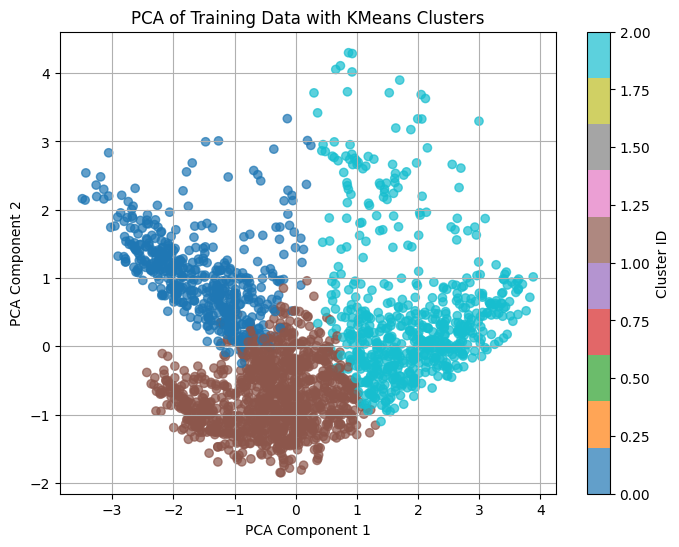

In [19]:
import matplotlib.pyplot as plt

# Assume 'train_pca' is the 2D PCA-transformed data
# and 'cluster' column contains cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=kmeans.labels_, cmap='tab10', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Training Data with KMeans Clusters')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()


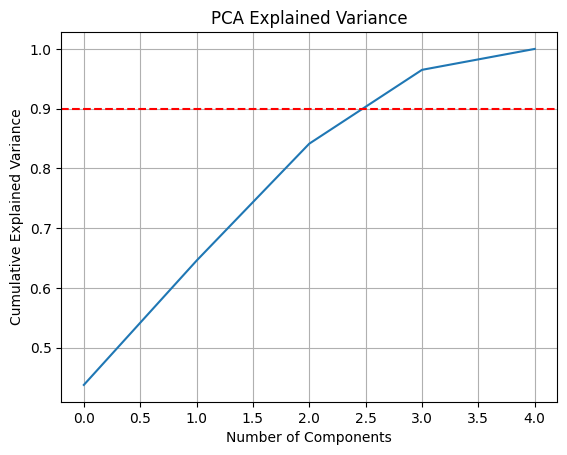

In [20]:

# Refit PCA with all components
pca_full = PCA().fit(train_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()


In [21]:
explained = pca.explained_variance_ratio_.sum()
print(f"PCA explains {explained:.2%} of the variance")

PCA explains 96.50% of the variance


In [22]:
train.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,cluster_0,cluster_1,cluster_2
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,True,False,False
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,True,False,False
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,False,False,True
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,True,False,False
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,True,False,False


## Prediction using Logistic Regression, XGBoost or LightGBM

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
import numpy as np
from lightgbm import LGBMClassifier


# Define a helper function to create the pipeline
def create_pipeline(lag_columns = config["lag_columns"], 
                    n_lags=config["n_lags"], 
                    clf=False):
    steps = [
        ('feature_eng', SeasonMonthTransformer()),
        ('additional_fe', AdditionalFeatureTransformer()),
        ('lag_features', LagFeatureTransformer(columns=lag_columns, n_lags=n_lags)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('clf', clf)
    ]
    return Pipeline(steps)

# Define your feature columns and data
features = [*config["features"], *[c for c in train.columns if c.startswith('cluster')]]

X = train[features]
y = train['rainfall']

# Create the logistic regression pipeline
pipeline_lg = create_pipeline(
    n_lags = config["n_lags"],
    lag_columns = config["lag_columns"],
    clf=LogisticRegression(
        penalty='l1',        # L1 (Lasso) regularization
        C=1.0,               # adjust for stronger/weaker regularization
        max_iter=1000,
        random_state=42,
        solver='liblinear'   # supports L1 penalty
    )
)

# Create the XGBoost pipeline 
pipeline_xgb = create_pipeline(
    n_lags = config["n_lags"],
    lag_columns = config["lag_columns"],
    clf=XGBClassifier(
        device=config["device"],
        n_estimators=10000,
        learning_rate=0.1,
        max_depth=6,
#        early_stopping_rounds=100,
        alpha=0.1,
        random_state=42,
        colsample_bytree=0.9, 
        subsample=0.9,
        use_label_encoder=False,    # Disable label encoder to avoid warnings
        eval_metric='auc'           # Set evaluation metric to AUC
    )
)

# Create the XGBoost pipeline (with a different lag configuration)
pipeline_lgbm = create_pipeline(
    n_lags = config["n_lags"],
    lag_columns = config["lag_columns"],
    clf=LGBMClassifier(
        device=config["device"],
        n_estimators=10000,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        verbose=-1  # This will suppress the warnings
    )
)



LightGBM Repeated CV AUC scores: [0.89590348 0.83636364 0.86537598 0.8620651  0.88392256 0.89267677
 0.85446128 0.88282828 0.82393378 0.84023569 0.86773288 0.84997194
 0.85432099 0.89834456 0.87707632 0.88709315 0.82067901 0.87710438
 0.88599888 0.89461279 0.85390011 0.88622334 0.89205948 0.86860269
 0.88378227 0.86529181 0.87387767 0.87699214 0.90718294 0.87763749
 0.84974747 0.88998316 0.88647587 0.85216049 0.86299102 0.85044893
 0.84166667 0.87923681 0.88235129 0.90319865 0.8879349  0.91111111
 0.80937149 0.86321549 0.88698092 0.84677329 0.90213244 0.88061167
 0.85861392 0.87306397]
Mean AUC LightGBM: 0.8711


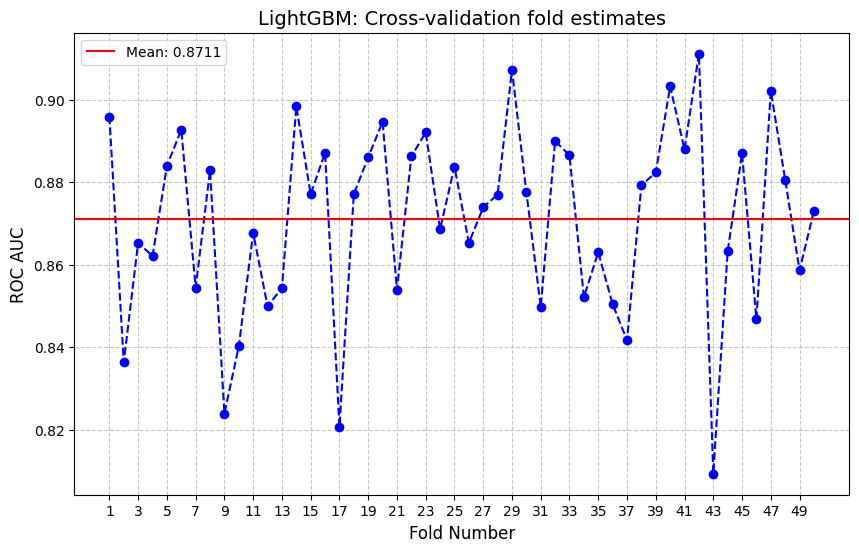

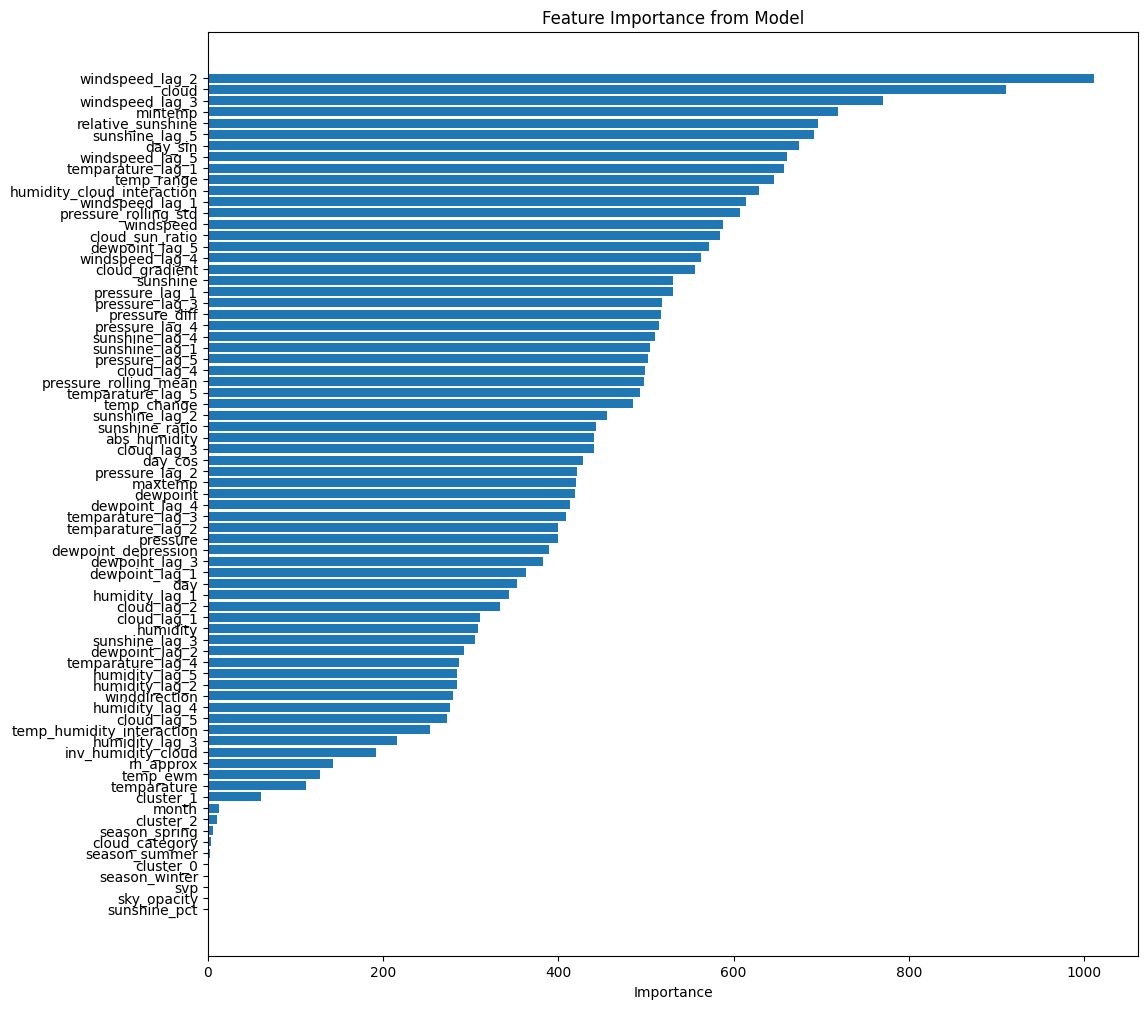

In [24]:
cv_scores_lgbm = evaluate_pipeline(pipeline_lgbm, X, y, "LightGBM")
mean_cv_scores_lgbm = np.mean(cv_scores_lgbm)
pipeline_lgbm.fit(X, y)
plot_feature_importance(pipeline_lgbm, X)


Logistic Regression Repeated CV AUC scores: [0.90690236 0.85751964 0.89520202 0.87216611 0.89163861 0.91801347
 0.88305275 0.90656566 0.86748036 0.8622615  0.87514029 0.86150393
 0.88549383 0.91116723 0.88434343 0.90474186 0.84991582 0.88274411
 0.91170034 0.88880471 0.86156004 0.88080808 0.90867003 0.88785073
 0.8884119  0.85875421 0.88375421 0.89938272 0.92157688 0.8712963
 0.86871493 0.89601571 0.89668911 0.86835017 0.88566218 0.85008418
 0.87314815 0.89478114 0.90297419 0.92774972 0.91989338 0.91823793
 0.82056678 0.8709596  0.9040404  0.8743266  0.90406846 0.87679574
 0.8818743  0.90232884]
Mean AUC Logistic Regression: 0.8863


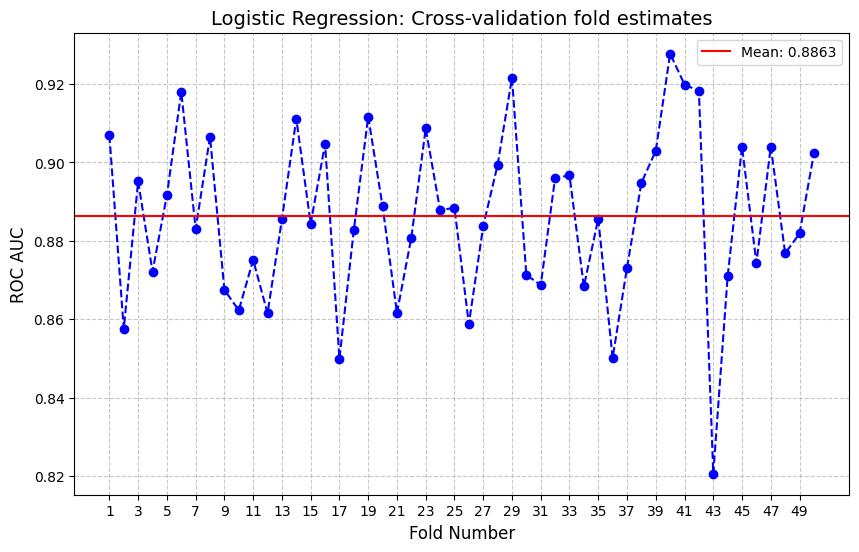

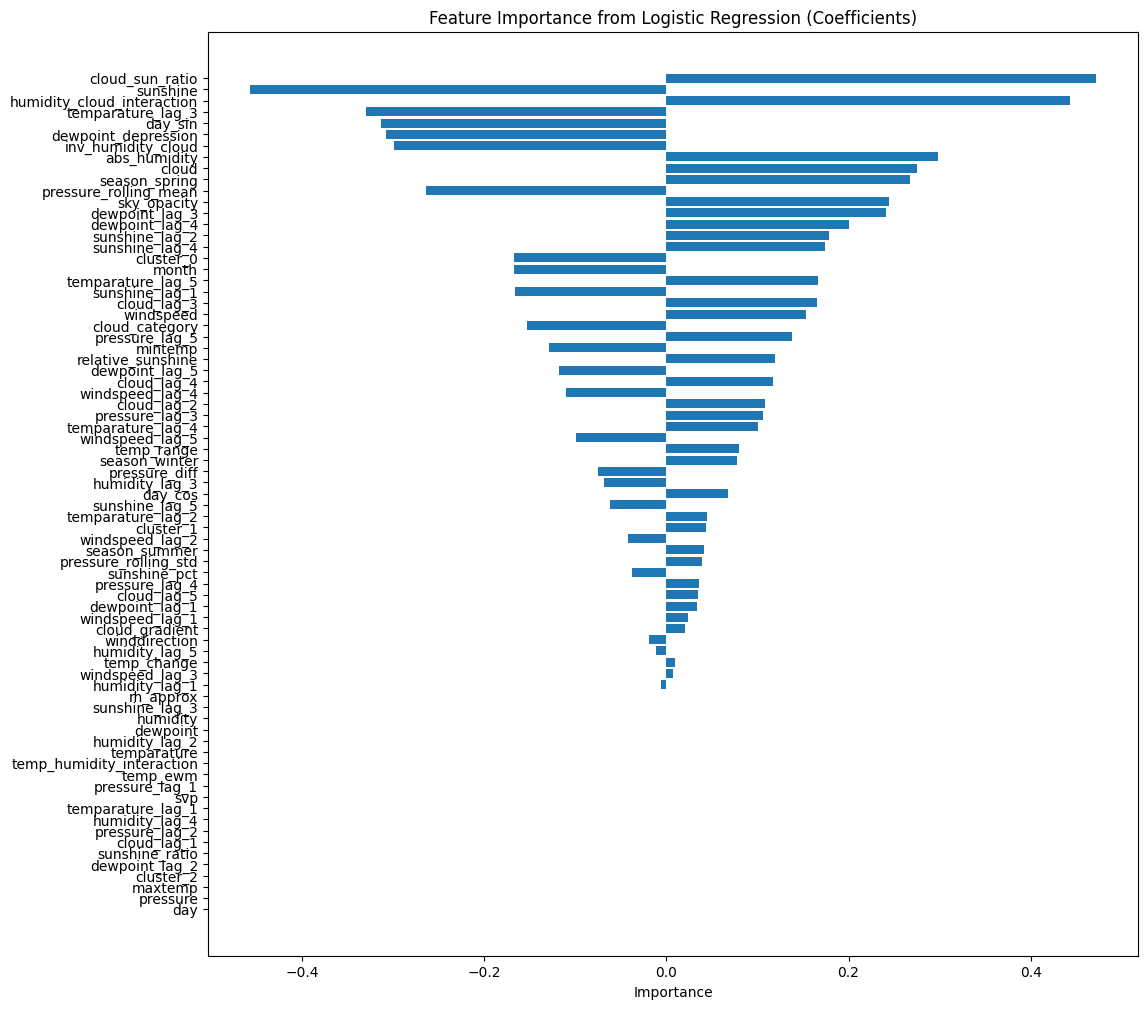

In [25]:
cv_scores_lg   = evaluate_pipeline(pipeline_lg, X, y, "Logistic Regression")
mean_cv_scores_lg = np.mean(cv_scores_lg)
pipeline_lg.fit(X, y)
plot_feature_importance(pipeline_lg, X)


XGBoost Repeated CV AUC scores: [0.89854097 0.83702301 0.87345679 0.85426487 0.89037598 0.89695567
 0.85597643 0.88852413 0.82727273 0.83947811 0.86181257 0.84318182
 0.86233165 0.90454545 0.86906566 0.89935466 0.82528058 0.87295174
 0.89131594 0.89241021 0.86074635 0.8772587  0.89069865 0.87003367
 0.86975309 0.85509259 0.86818182 0.86759259 0.90274972 0.86484287
 0.83406285 0.88947811 0.89553872 0.85182379 0.86764871 0.85207632
 0.85412458 0.8801908  0.87707632 0.91099888 0.88508698 0.9119248
 0.81661055 0.86902357 0.88738777 0.85047699 0.9026936  0.88104658
 0.8562009  0.87669753]
Mean AUC XGBoost: 0.8712


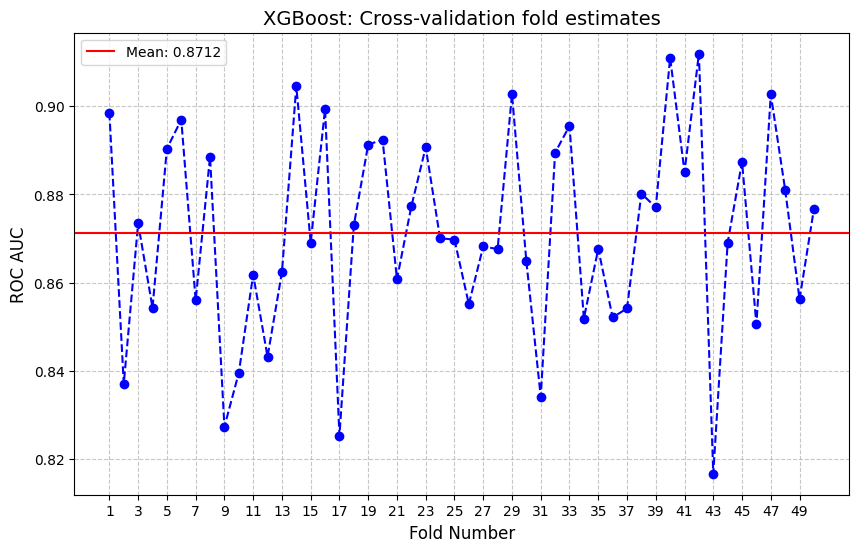

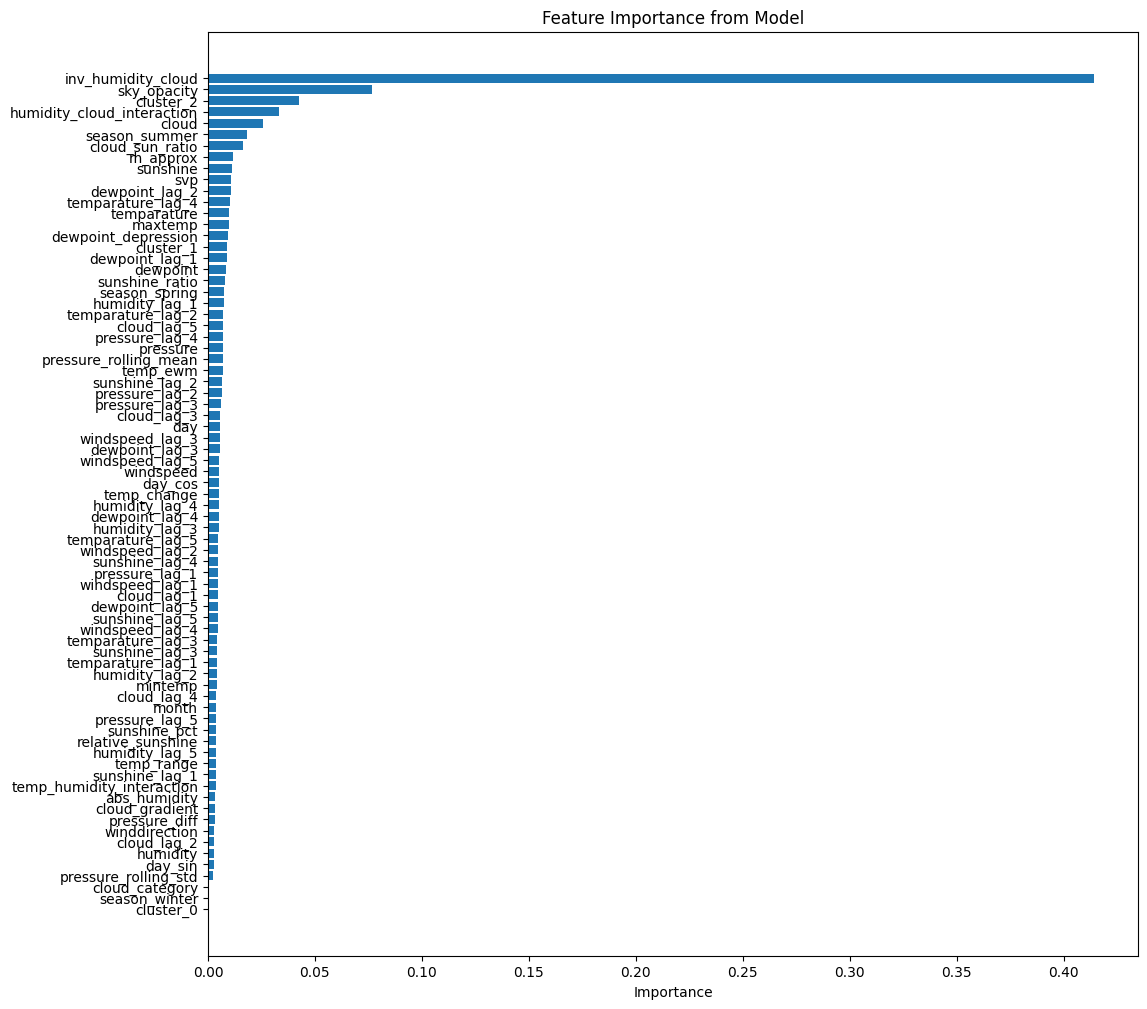

In [26]:
cv_scores_xgb  = evaluate_pipeline(pipeline_xgb, X, y, "XGBoost")
mean_cv_scores_xgb = np.mean(cv_scores_xgb)
pipeline_xgb.fit(X, y)
plot_feature_importance(pipeline_xgb, X)


## Choose a model

Modify this variable to choose which model to submit

In [27]:
from sklearn.ensemble import VotingClassifier

# Suppose these are your mean cross‑validation AUROC scores:
results = {"LG": mean_cv_scores_lg, "XGB": mean_cv_scores_xgb, "LGBM": mean_cv_scores_lgbm}
print("CV results:", results)

# Normalize the weights so they sum to 1:
total_score = mean_cv_scores_lg + mean_cv_scores_xgb + mean_cv_scores_lgbm
weights = [mean_cv_scores_lg / total_score, mean_cv_scores_xgb / total_score, mean_cv_scores_lgbm / total_score]
print("Normalized weights:", weights)

# Create a voting ensemble using soft voting (using predicted probabilities)
pipeline = VotingClassifier(estimators=[
    ('LG', pipeline_lg),
    ('XGB', pipeline_xgb),
    ('LGBM', pipeline_lgbm)
], voting='soft', weights=weights)



CV results: {'LG': 0.8863136924803591, 'XGB': 0.8712247474747475, 'LGBM': 0.8710864197530863}
Normalized weights: [0.33717770308949674, 0.3314374602587694, 0.33138483665173385]


In [28]:
## Dictionary mapping model names to their mean cross-validation scores
#results = {"LG": mean_cv_scores_lg, "XGB": mean_cv_scores_xgb, "LGBM": mean_cv_scores_lgbm}#
#
## Get the best model key and score
#best_model, best_score = max(results.items(), key=lambda x: x[1])
#print("Best model:", best_model, "with score:", best_score)

## Dictionary mapping model names to their corresponding pipelines
#pipelines = {"LG": pipeline_lg, "XGB": pipeline_xgb, "LGBM": pipeline_lgbm}

## Assign the pipeline corresponding to the best model
#pipeline = pipelines[best_model]


In [29]:
#pipeline = pipeline_lg

## Fitting model

In [30]:
# Refit on the full training set to ensure coefficients are available
pipeline.fit(X, y)


VotingClassifier(estimators=[('LG',
                              Pipeline(steps=[('feature_eng',
                                               SeasonMonthTransformer()),
                                              ('additional_fe',
                                               AdditionalFeatureTransformer()),
                                              ('lag_features',
                                               LagFeatureTransformer(columns=['humidity',
                                                                              'temparature',
                                                                              'pressure',
                                                                              'cloud',
                                                                              'windspeed',
                                                                              'dewpoint',
                                                                              'sunshine'])),
                                              ('imputer', SimpleImputer()),
                                              ('scaler', StandardScaler()),
                                              ('clf',
                                               LogisticRegression...
                                               LagFeatureTransformer(columns=['humidity',
                                                                              'temparature',
                                                                              'pressure',
                                                                              'cloud',
                                                                              'windspeed',
                                                                              'dewpoint',
                                                                              'sunshine'])),
                                              ('imputer', SimpleImputer()),
                                              ('scaler', StandardScaler()),
                                              ('clf',
                                               LGBMClassifier(device='cpu',
                                                              max_depth=6,
                                                              n_estimators=10000,
                                                              random_state=42,
                                                              verbose=-1))]))],
                 voting='soft',
                 weights=[0.33717770308949674, 0.3314374602587694,
                          0.33138483665173385])

## Creating Submission file

In [31]:
X_test = test[features]
X_test

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,cluster_0,cluster_1,cluster_2
0,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3,True,False,False
1,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3,True,False,False
2,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9,True,False,False
3,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6,True,False,False
4,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,361,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3,False,True,False
726,362,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2,False,True,False
727,363,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9,False,True,False
728,364,1014.4,21.0,20.0,19.7,19.8,94.0,93.0,0.0,50.0,39.5,False,True,False


In [32]:
pipeline.fit(X,y)
# Predict probabilities on the test set
test_preds = pipeline.predict_proba(X_test)[:, 1]

# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],
    'rainfall': test_preds
})

# Save the submission file
submission.to_csv('submission.csv', index=False)


In [33]:
test_preds[0:10]

array([0.99763418, 0.99801785, 0.99139121, 0.07093673, 0.0286788 ,
       0.98233502, 0.98651448, 0.9888235 , 0.9918932 , 0.94705452])

In [34]:
submission.head()

,id,rainfall
0,2190,0.997634
1,2191,0.998018
2,2192,0.991391
3,2193,0.070937
4,2194,0.028679
